---
title: "Image Classification with TensorFlow Keras"
date: "2021-12-02"
image: "image.png"
format:
  html:
    code-fold: show
    code-line-numbers: false
jupyter: python3
---

In this post, we'll go through a workflow in TensorFlow for finetuning a pretrained model for image classification. We'll use [this](https://www.kaggle.com/competitions/flower-classification-with-tpus/data) dataset that contains images of 104 types of flowers as an example. Let's dive right in.

In [1]:
#| code-fold: true

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import re
from pathlib import Path

## Setup

### Mixed precision

On GPUs with Tensor Cores (i.e., GPUs with [compute capability of at least 7.0](https://developer.nvidia.com/cuda-gpus)) training with mixed precision can provide significant speedups. Mixed precision translates to running operations in float16 if possible while keeping variables and some computations in float32 for numeric reasons. This speeds up reading from memory as well as run times, and often allows to double the batch size.

To use mixed precision in Keras, we need to set a global policy:

In [3]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

Important:

- In order to guarantee numeric stability, the outputs of our model's last layer have to be in float32. Since each Keras layer uses the global policy by default, we have to specify the corresponding `dtype` explicitly.
- Tensor Cores require most tensor dimensions to be a multiple of 8. See Nvidia's [performance guide](https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/index.html) for details.
- If we implement a custom training loop (i.e., if we don't use `tf.keras.Model.fit()`), we have to prevent our gradients from underflowing to zero by using loss scaling. See this [guide](https://www.tensorflow.org/guide/mixed_precision#loss_scaling_overview) for more.
- On CPUs float16 operations are slower than float32 operations. Thus, input processing on the CPU should generally be in float32.

### Distribution Strategy

TensorFlow offers the `tf.distribute.Strategy` API to easily scale model training onto multiple GPUs, multiple machines, or TPUs. The following three strategies are the most common:

- `tf.distribute.MirroredStrategy`: Use this strategy when using a single machine with one or more GPUs. Replicates the model graph and all variables on each available GPU and distributes the input evenly across all replicas. Each replica calculates the gradients for its input; the gradients are synced across all replicas by summing them so that the same update is made on all replicas.
- `tf.distribute.MultiWorkerMirroredStrategy`: Extends the `MirroredStrategy` to a multi-machine setup. Requires [setting up the `TF_CONFIG` environment variable](https://www.tensorflow.org/guide/distributed_training#TF_CONFIG) correctly.
- `tf.distribute.TPUStrategy`: The strategy when using Google's TPUs.

Here we'll use `tf.distribute.MirroredStrategy` since we want to train on two GPUs. For more on distributed training with TensorFlow, see the corresponding [guide](https://www.tensorflow.org/guide/distributed_training).

In [4]:
strategy = tf.distribute.MirroredStrategy()
print("# replicas:", strategy.num_replicas_in_sync)

# replicas: 2


### Autotune

When using TensorFlow's `tf.data` API, we can use `AUTOTUNE` to automatically optimize the allocation of the CPU budget to speed up the input pipeline. We'll see soon how this plays out.

In [5]:
AUTO = tf.data.AUTOTUNE

## Loading the data

In [6]:
#| code-fold: true

BATCH_SIZE = 32 * strategy.num_replicas_in_sync
IMAGE_SIZE = (331, 331)
DATA_DIR = f"{base_path}/tfrecords-jpeg-{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}"

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose'] 

### Working with TFRecords

In this example, the data is available in multiple [TFRecord](https://www.tensorflow.org/tutorials/load_data/tfrecord) files. TFRecord is an efficient format for storing a sequence of binary records allowing very fast I/O operations. To easily stream the contents of one or more TFRecord files, we can use the `tf.data` API (more specifically, the [`tf.data.TFRecordDataset`](https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset) class; we just need to pass in a list of filenames).

In [7]:
raw_paths = tf.io.gfile.glob(DATA_DIR + "/train/*.tfrec")
raw_dataset = tf.data.TFRecordDataset(raw_paths)

In [8]:
for example in raw_dataset.take(3):
    print(repr(example)[:300])

<tf.Tensor: shape=(), dtype=string, numpy=b'\n\xa3\xb6\x02\n\x13\n\x02id\x12\r\n\x0b\n\t05fa7d4ca\n\x0e\n\x05class\x12\x05\x1a\x03\n\x01f\n\xfa\xb5\x02\n\x05image\x12\xef\xb5\x02\n\xeb\xb5\x02\n\xe7\xb5\x02\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x0
<tf.Tensor: shape=(), dtype=string, numpy=b'\n\xaf\xde\x03\n\x13\n\x02id\x12\r\n\x0b\n\tbafaca028\n\x0e\n\x05class\x12\x05\x1a\x03\n\x01\x08\n\x86\xde\x03\n\x05image\x12\xfb\xdd\x03\n\xf7\xdd\x03\n\xf3\xdd\x03\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01
<tf.Tensor: shape=(), dtype=string, numpy=b'\n\xee\xc5\x03\n\x0e\n\x05class\x12\x05\x1a\x03\n\x01\x0e\n\xc5\xc5\x03\n\x05image\x12\xba\xc5\x03\n\xb6\xc5\x03\n\xb2\xc5\x03\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x0


As we can see, we'll have to decode the examples. For this purpose, we can use the following function that takes in a raw example and returns the image and its class label. Since we'll use MixUp later, we need to return the one-hot encoded class labels. Also, we ignore the `id` feature since we won't need it.

In [9]:
def parse_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),
        "id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    label = tf.one_hot(tf.cast(example['class'], tf.int32), len(CLASSES))
    return image, label

Now we can read in the entire dataset using the function below. To benefit from parallelization (if possible), we can set `num_parallel_reads=AUTO`. For more on defining and reading TFRecords, see [here](https://keras.io/examples/keras_recipes/creating_tfrecords/#define-dataset-helper-functions).

In [10]:
def load_dataset(filenames):    
    dataset = (
        tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
        .map(parse_tfrecord, num_parallel_calls=AUTO)
    )
    
    return dataset

### Creating training and validation splits

While stratified k-fold cross-validation (CV) would certainly be the best way to evaluate our training procedure, we'll opt for a basic train-validation split to avoid unnecessary energy consumption and keep things simple. Also, the dataset already comes with predefined folders containing the images for training, validation and testing, respectively. To load the images, we simply gather the corresponding filenames.

In [11]:
#| code-fold: true
TRAIN_FILENAMES = tf.io.gfile.glob(DATA_DIR + '/train/*.tfrec')
VALID_FILENAMES = tf.io.gfile.glob(DATA_DIR + '/val/*.tfrec')

def count_data_items(filenames):
    # the name of the .tfrec files contains the number of images in the corresponding file
    # 00-224x224-462.tfrec = 462 examples
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

num_training_images = count_data_items(TRAIN_FILENAMES)
num_validation_images = count_data_items(VALID_FILENAMES)
print("Training images:", num_training_images)
print("Validation images:", num_validation_images)

Training images: 12753
Validation images: 3712


### Data augmentation

For data augmentation, we begin by defining some basic transformations using `tf.image` methods. Note that we could also do this in Keras layers. To show that we can use Keras layers for preprocessing, we'll add a `RandomCrop` layer at the beginning of our model (we could have done this in the data augmentation function too).

In [12]:
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.5, 2.)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    return image, label

We also implement the [MixUp](https://arxiv.org/abs/1710.09412) augmentation technique.

In [13]:
MIXUP_FRAC = 0.4

def mixup(img, label):
    def _interpolate(b1, b2, t):
        return t*b1 + (1-t)*b2

    n = np.rint(MIXUP_FRAC * len(img)).astype(np.int32)
    t = np.round(np.random.uniform(0.5, 0.8), 2)
    
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    img1, label1 = img[:n], label[:n]
    img2, label2 = img[1:n+1], label[1:n+1]
    interp_img = _interpolate(img1, img2, t)
    interp_label = _interpolate(label1, label2, t)
       
    img = tf.concat([interp_img, img[n:]], axis=0)
    label = tf.concat([interp_label, label[n:]], axis=0)
    
    img = tf.image.convert_image_dtype(img, tf.uint8)
    
    return img, label

### Loading the training and validation data

Now we are ready to define the functions for loading the training and validation data. We begin with `get_training_dataset()`:

In [14]:
def get_training_dataset():
    dataset = load_dataset(TRAIN_FILENAMES)
    dataset = (
        dataset.map(augment_data, num_parallel_calls=AUTO)
               .repeat()
               .shuffle(BATCH_SIZE * 8)
               .batch(BATCH_SIZE, drop_remainder=True)
               .map(mixup)
               .prefetch(AUTO)
    )
    return dataset

Let's go through the method calls:

- `map(augment_data)`: We start with applying the augmentations defined in the `augment_data` function.
- `repeat()`: In practice, we often want to train for a fixed number of training examples instead of a fixed number of epochs. We call `repeat()` to avoid problems when we overestimate the size of our training dataset. If we underestimate the number of training examples, the remaining examples simply carry over to the next epoch. Note that computing the required number of steps for a (virtual) epoch is easy: `steps_per_epoch = num_training_examples // batch_size`. 
- `shuffle()`: In general, we want batches that contain different training examples (as opposed to batches with many similar examples, e.g., only images of roses). Thus, we randomize the examples by shuffling within a buffer that is (much) larger than the batch size. The size of the buffer should depend on how ordered the dataset is. (If the dataset is sorted by label, the buffer size has to cover the entire dataset. In that case, we should already shuffle the data when preparing the training dataset.)
- `batch()`: Creates the batches of our desired batch size. The best batch size usually is the largest batch size that fits our machine.
- `map(mixup)`: Since our implementation of mixup works with batches, we have to make the corresponding `map` call after the `batch()` operation.
- `prefetch()`: Prefetching uses a background thread to prefetch elements from the input dataset needed for the next training step while the current training step is executed. We can set the number of elements that should be prefetched to `tf.data.AUTOTUNE` which automatically determines the value at runtime.

In [15]:
def get_validation_dataset():
    dataset = load_dataset(VALID_FILENAMES)
    dataset = (
        dataset.batch(BATCH_SIZE)
               .prefetch(AUTO)
    )
    return dataset

In [16]:
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()

More on optimizing the input pipeline using the `tf.data` API can be found in this [guide](https://www.tensorflow.org/guide/data_performance).

### Visualize examples

Finally let's have a look at some examples (normally we would have inspected the images right away, of course, but we skipped this step for the sake of brevity).

In [17]:
#| code-fold: true
def get_n_examples_as_np(dataset, n):
    dataset = dataset.unbatch().batch(n)
    for images, labels in dataset:
        np_images = images.numpy()
        np_labels = labels.numpy()
        break
    return np_images, np_labels

In [18]:
#| code-fold: true
def display_example(image, oh_labels=None, fontsize=13):
    plt.imshow(image)
    if oh_labels is not None:
        label_idxs = np.nonzero(oh_labels)[0]
        labels = np.array(CLASSES)[label_idxs]
        vals = list(map(str, list(oh_labels[label_idxs])))
        title = "\n".join(" ".join(lb) for lb in zip(vals, labels))
        plt.title(title, fontsize=fontsize)
    plt.show();

In [19]:
#| code-fold: true
imgs, lbls = get_n_examples_as_np(train_dataset, 9)

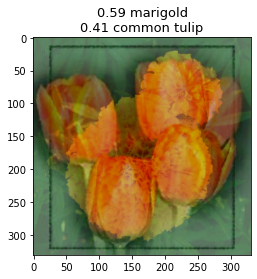

In [20]:
#| code-fold: true
display_example(imgs[0], np.array(lbls[0]))

In [21]:
#| code-fold: true
def display_examples(images, oh_labels=None, figsize=(10, 10), fontsize=13, axis_off=True):
    plt.figure(figsize=figsize)
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        if oh_labels is not None:
            label_idxs = np.nonzero(oh_labels[i])[0]
            labels = np.array(CLASSES)[label_idxs]
            vals = list(map(str, list(oh_labels[i][label_idxs])))
            title = "\n".join(" ".join(lb) for lb in zip(vals, labels))
            plt.title(title, fontsize=fontsize)
        if axis_off:
            plt.axis("off")
    plt.tight_layout()

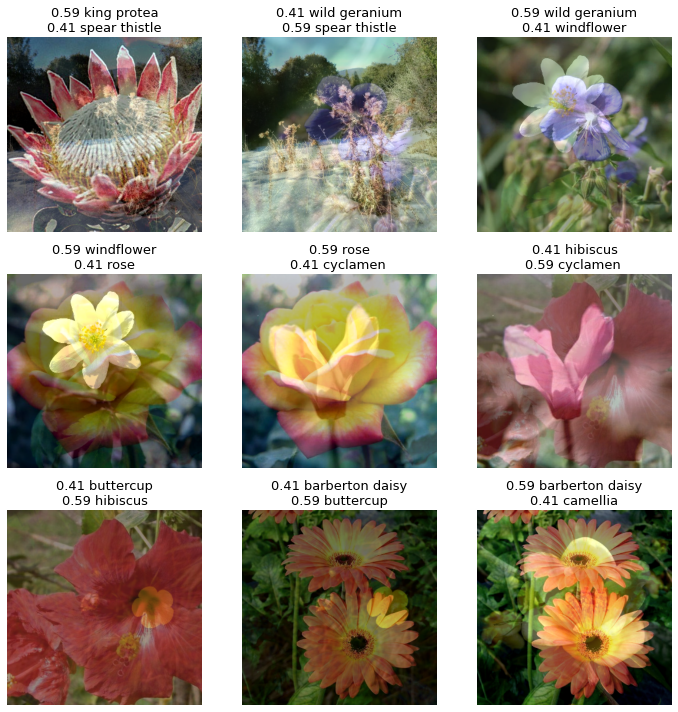

In [22]:
#| code-fold: true
imgs, lbls = get_n_examples_as_np(train_dataset, 9)
display_examples(imgs, lbls)

## Finetuning

### Defining the model

When it comes to choosing a pretrained model, there are a lot of great options. Here, we'll just use a model from the EfficientNet family that is available in `tf.keras.applications` (if a model is not yet available within Keras, it can usually be downloaded from the [TensorFlow Hub](https://www.tensorflow.org/hub)). In particular, we'll use a pretrained `EfficientNetB3` which takes input images of shape `(300, 300, 3)`. See [here](https://arxiv.org/abs/1905.11946) for the original paper and [here](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/) for some practical information regarding finetuning EfficientNets.

A few notes:

- We want to obtain a 3D feature map from the pretrained model that we can combine with a custom classification head. Thus, we set `include_top=False`.
- Since we want to finetune the model (as opposed to transfer learning), we have to set the `trainable` flag to `True`.
- To apply the appropriate preprocessing for the model (e.g., converting the pixel values to a specific range like `[0,1]` or `[-1, 1]`), we use a `Lambda` layer that wraps the `preprocess_input` function that comes with the model.

The layers that follow the pretrained model are simple:

- `GlobalAveragePooling2D` averages the values in each channel of the final feature map. Note that this averaging procedure removes positional information that is present in the channels (in classification tasks this usually doesn't matter; however, it is generally not a good choice in tasks like object detection).
- We include a `Dropout` layer to reduce overfitting.
- As usual, the final `Dense` layer, combined with the softmax activation, allows us to obtain the class probabilities.

To apply the distribution strategy discussed earlier, we have to define the model within a corresponding context manager (`with strategy.scope():`).

In [23]:
with strategy.scope():
    pretrained_model = tf.keras.applications.EfficientNetB3(weights="imagenet", include_top=False, input_shape=[300, 300, 3])
    pretrained_model.trainable = True
    
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer((331, 331, 3)),
        tf.keras.layers.RandomCrop(height=300, width=300),
        tf.keras.layers.Lambda(lambda data: tf.keras.applications.efficientnet.preprocess_input(tf.cast(data, tf.float32)), input_shape=[300, 300, 3]),
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(CLASSES), name="last_dense"),
        tf.keras.layers.Activation("softmax", dtype="float32", name="predictions")
    ])
    
model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)
model.summary()

43950080/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_crop (RandomCrop)     (None, 300, 300, 3)       0         
_________________________________________________________________
lambda (Lambda)              (None, 300, 300, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
last_dense (Dense)           (None, 104)               159848    
_________________________________________________________

### Learning rate schedule

It can be tricky to find a learning rate that works well in a finetuning task. Let's try the following learning schedule that combines warm-up period and an exponential decay. The implementation below is an example:

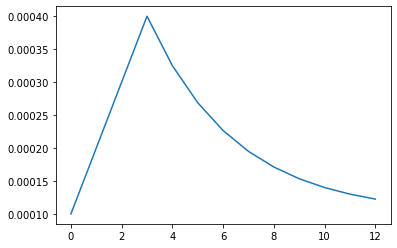

In [24]:
#| code-fold: true
EPOCHS = 13

start_lr = 0.0001
min_lr = 0.0001
max_lr = 0.0002 * strategy.num_replicas_in_sync
rampup_epochs = 3
sustain_epochs = 0
exp_decay = 0.75

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y);

Another option that can work very well is using differential learning rates (i.e., different learning rates for different layers of the model). Intuitively, we'll want low learning rates for the pretrained layers and a normal learning rate for the layers of our custom classification head. Note that differential learning rates can be combined with a learning rate scheduler.

### Fitting the model

In [25]:
STEPS_PER_EPOCH = num_training_images // BATCH_SIZE
VALIDATION_STEPS = -(-num_validation_images // BATCH_SIZE)

In [26]:
#| output: false
history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS,
                    validation_data=valid_dataset, 
                    validation_steps=VALIDATION_STEPS,
                    callbacks=[lr_callback])

Epoch 1/13

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
199/199 [==============================] - 255s 931ms/step - loss: 3.2621 - accuracy: 0.3410 - val_loss: 1.5115 - val_accuracy: 0.6859
Epoch 2/13

Epoch 00002: LearningRateScheduler setting learning rate to 0.0002.
199/199 [==============================] - 181s 909ms/step - loss: 1.8103 - accuracy: 0.6578 - val_loss: 0.6041 - val_accuracy: 0.8702
Epoch 3/13

Epoch 00003: LearningRateScheduler setting learning rate to 0.00030000000000000003.
199/199 [==============================] - 169s 851ms/step - loss: 1.4432 - accuracy: 0.7392 - val_loss: 0.4892 - val_accuracy: 0.8976
Epoch 4/13

Epoch 00004: LearningRateScheduler setting learning rate to 0.0004.
199/199 [==============================] - 171s 858ms/step - loss: 1.2996 - accuracy: 0.7710 - val_loss: 0.4229 - val_accuracy: 0.9027
Epoch 5/13

Epoch 00005: LearningRateScheduler setting learning rate to 0.00032500000000000004.
199/199 [===================

In [27]:
#| code-fold: true
def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

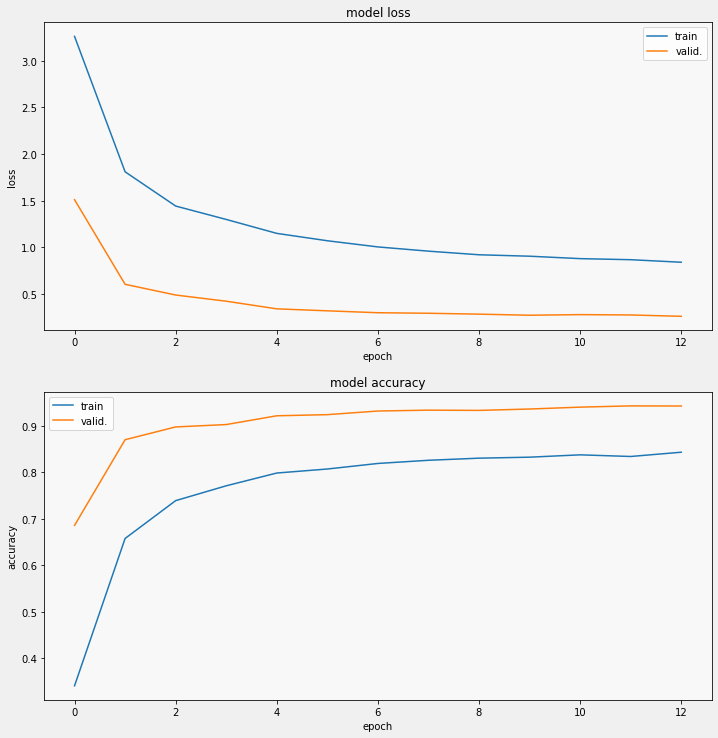

In [28]:
#| code-fold: true
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)

In [29]:
#| code-fold: true
os.mkdir("export")
model.save("export/effnetb3_flowers_01")

### Visual checks

Let's have a look at some predictions on the validation data.

In [30]:
#| code-fold: true
valid_dataset = get_validation_dataset()
valid_dataset = valid_dataset.unbatch().batch(9)
batch = iter(valid_dataset)

In [31]:
#| code-fold: true
imgs, lbls = next(batch)
probs = model.predict(tf.cast(imgs, tf.float32))
preds = np.argmax(probs, axis=-1)

In [32]:
#| code-fold: true
def display_predictions(images, oh_labels, preds, figsize=(10, 10), fontsize=13, axis_off=True):
    plt.figure(figsize=figsize)
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        if oh_labels is not None:
            label_idx = np.argmax(oh_labels[i])
            label = np.array(CLASSES)[label_idx]
            pred = np.array(CLASSES)[preds[i]]
            title = f"Correct: {label}\nPredicted: {pred}"
            color = "red" if label != pred else "black"
            plt.title(title, fontsize=fontsize, color=color)
        if axis_off:
            plt.axis("off")
    plt.tight_layout()

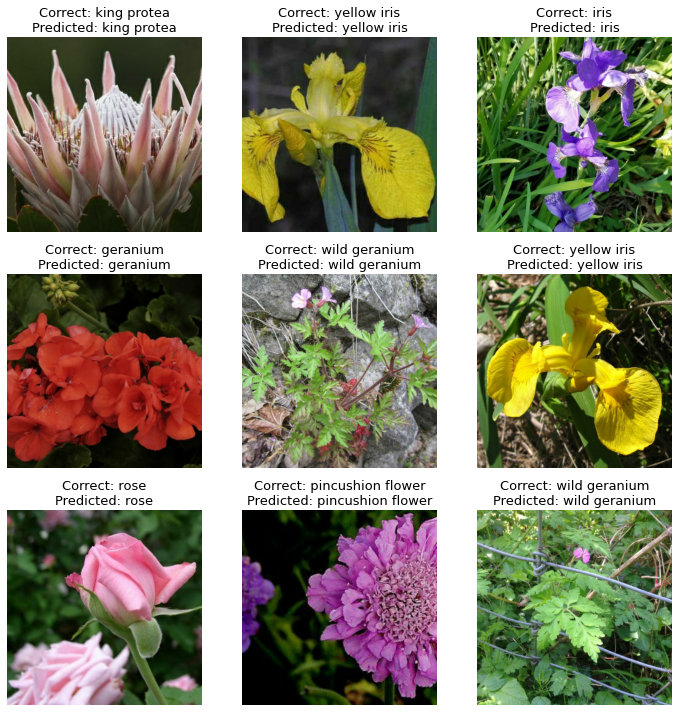

In [33]:
#| code-fold: true
display_predictions(imgs, lbls, preds)

Additionally, we can also plot the corresponding confusion matrix:

In [34]:
#| code-fold: true
cm_dataset = get_validation_dataset() 
img_dataset = cm_dataset.map(lambda image, label: image)
lbl_dataset = cm_dataset.map(lambda image, label: label).unbatch()
cm_correct_lbls = next(iter(lbl_dataset.batch(num_validation_images))).numpy()
cm_correct_lbls = np.argmax(cm_correct_lbls, axis=-1)
cm_probs = model.predict(img_dataset, steps=VALIDATION_STEPS)
cm_preds = np.argmax(cm_probs, axis=-1)

In [35]:
#| code-fold: true
cmat = confusion_matrix(cm_correct_lbls, cm_preds, labels=range(len(CLASSES)))
cmat = (cmat.T / cmat.sum(axis=1)).T

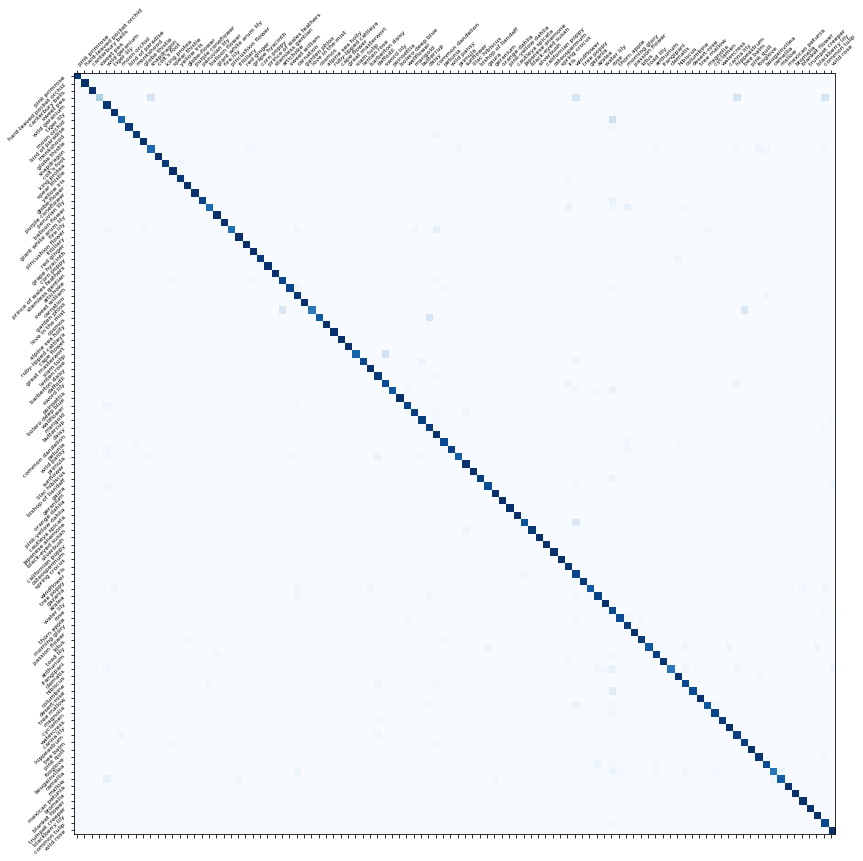

In [36]:
#| code-fold: true
fig, ax = plt.subplots(figsize=(14, 14))
ax.matshow(cmat, cmap="Blues")
ax.set_xticks(range(len(CLASSES)))
ax.set_xticklabels(CLASSES, fontdict={'fontsize': 6}, rotation=45, ha="left")
ax.set_yticks(range(len(CLASSES)))
ax.set_yticklabels(CLASSES, fontdict={'fontsize': 6}, rotation=45);

In [37]:
#| code-fold: true
score = f1_score(cm_correct_lbls, cm_preds, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_lbls, cm_preds, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_lbls, cm_preds, labels=range(len(CLASSES)), average='macro')
print(f"F1 score:\t{score:.3f}\nPrecision:\t{precision:.3f}\nRecall:\t\t{recall:.3f}")

F1 score:	0.941
Precision:	0.953
Recall:		0.936


### Prediction

As a final step, we want to obtain the model's predictions on the test set.

In [38]:
#| code-fold: true
TEST_FILENAMES = tf.io.gfile.glob(DATA_DIR + '/test/*.tfrec')
num_test_images = count_data_items(TEST_FILENAMES)
TEST_STEPS = -(-num_test_images // BATCH_SIZE) 

In [39]:
#| code-fold: true
def parse_tfrecord_test(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    idnum = example["id"]
    return image, idnum

def get_test_dataset():
    dataset = (
        tf.data.TFRecordDataset(TEST_FILENAMES, num_parallel_reads=AUTO)
        .map(parse_tfrecord_test, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )
    return dataset

In [40]:
#| code-fold: true
test_dataset = get_test_dataset()
test_img_dataset = test_dataset.map(lambda img, idn: img)
test_ids_dataset = test_dataset.map(lambda img, idn: idn).unbatch()
test_ids = next(iter(test_ids_dataset.batch(num_test_images))).numpy().astype("U")
probs = model.predict(test_img_dataset, steps=TEST_STEPS)
preds = np.argmax(probs, axis=-1)